# Simulations

A significant part of the [Stochastic Matching package](https://balouf.github.io/stochastic_matching/index.html) is devoted to simulations, allowing to check the practical value of theoretical results and to explore new conjectures.

First, some settings that should apply to all our simulations.

:::note
The *refresh* parameter below tells if the simulation should run if a simulation file already exists.
:::

In [1]:
refresh = False
n_steps = 10**7
common = {
        "n_steps": n_steps,
        "max_queue": 50000,
        "seed": 42,
}

## Approaching vertices

### Preparation

First, we define the set of simulations we want to run. Let's make a small mixer of common and specific parameters.

In [2]:
import numpy as np
from stochastic_matching import XP, Iterator, evaluate
from multiprocess import Pool
from numba import njit

def xp_builder(common, specific):
    return sum([XP(name=k, **common, **v) for k, v in specific.items()])

Prepare specific parameters for each policy. For now, *taboo* (a.k.a. forbidden edges), which is adapted to bijective vertices, is left alone.

In [3]:
k_range = Iterator("k", [2**i for i in range(12)])
e_range = Iterator("epsilon", np.logspace(-3, 0, 10), name="ϵ")
b_range = Iterator("beta", np.logspace(-3, 1, 10), name="β")
def exp_fad(x):
    return njit(lambda t: (t+1)**x)
v_range = Iterator("fading", [exp_fad(x) for x in np.linspace(0., 1., 10)], name="V")

specific = {
    'k-filtering': {'simulator': "longest", 'forbidden_edges': True, 
                    'iterator': k_range},
    'EGPD': {'simulator': "virtual_queue", 
             'iterator': b_range},
    "ϵ-filtering": {'simulator': "e_filtering", 
                    'iterator': e_range},
    "EGPD+": {'simulator': "virtual_queue", 'alt_rewards': 'gentle', 
              'iterator':  b_range},
    "CRPD": {'simulator': 'constant_regret', 
             'iterator': v_range}
           }
taboo = {'simulator': 'longest', 'forbidden_edges': True}

Finally, a display function with a few options.

In [4]:
import matplotlib.pyplot as plt
def display_res(res, view="loglog", x_max=None, y_min=10**-8, y_max=None):
    if view == "loglog":
        plot = plt.loglog
    elif view == "logx":
        plot = plt.semilogx
    else:
        raise ValueError(f"{view} is not a recognized display view.")
    names = [k for k in res] 
    colors = {k: v for k, v in zip(names, 
                                   plt.rcParams['axes.prop_cycle'].by_key()['color'])}
    for k in sorted(names, key=lambda k: -np.average(res[k]['regret'])):
        v = res[k]
        delay, regret = np.array(v["delay"]), np.array(v["regret"])
        if isinstance(v["delay"], list):
            mask = delay > 0
            plot(np.abs(delay[mask]), np.abs(regret[mask]), marker="o", 
                 label=k, color=colors[k])
        else:
            if y_max is None:
                plot([delay], [regret], marker="o", label=k, color=colors[k])
            else:
                plot([delay, delay], [y_min, y_max], '--', label=k, color=colors[k])
                
    plt.ylabel("Regret")
    plt.xlabel("Delay")
    if view == "logx":
        plt.ylim([0, None])
    plt.xlim([None, x_max])
    if y_max:
        plt.ylim([y_min, y_max])
    plt.legend()
    plt.show()

### Diamond

#### Injective-only vertex

Let's reach an injective-only vertex.

In [5]:
import stochastic_matching as sm
diamond = sm.CycleChain()
rewards = [1, 2.9, 1, -1, 1]
print(diamond.optimize_rates(rewards))

[2. 0. 1. 0. 2.]


:::note
The rewards are adversarial here: the largest reward corresponds to a taboo edge.
:::

Let us compute the delay/regret trade-offs and display the results.

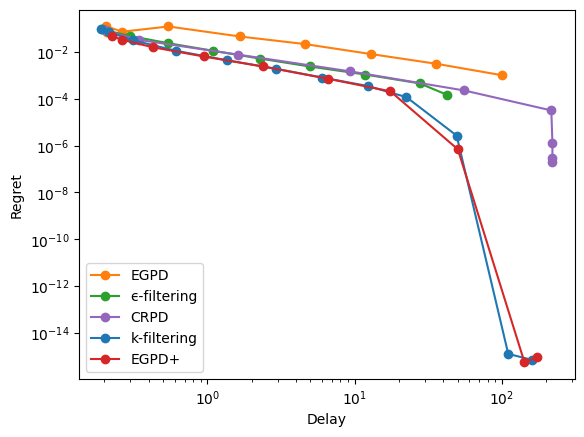

In [6]:
xps = xp_builder({'model': diamond, 'rewards': rewards, **common}, specific)
with Pool() as p:
    res = evaluate(xps, pool=p, cache_name="diamond-injective", 
                   cache_overwrite=refresh)
display_res(res)

Take-away:

- EGPD has not a good trade-off;
- $\epsilon$-filtering and CRPD have average performance;
- $k$-filtering and EGPD+ are the best here.

#### Bijective vertex

We now change the rates and rewards so that the target is a bijective vertex.

In [7]:
diamond.rates = [4, 4, 4, 2]
rewards = [-1, 1, 1, 1, 2.9]
diamond.optimize_rates(rewards)

array([1., 3., 1., 2., 0.])

:::note
The rewards are even more adversarial here: the largest reward corresponds the unique taboo edge, while a live edge has a negative reward.
:::

As before, let's see the trade-offs.

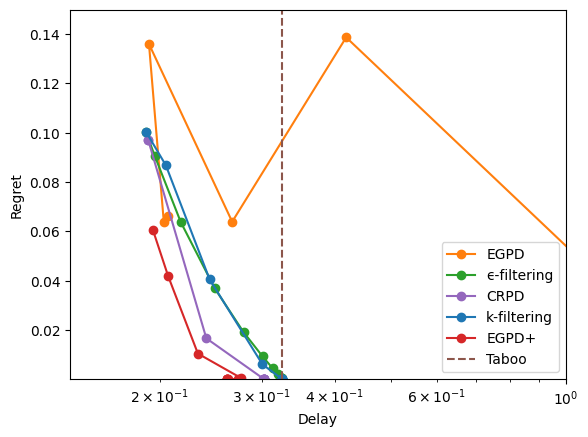

In [8]:
specific['Taboo'] = taboo
xps = xp_builder({'model': diamond, 'rewards': rewards, **common}, specific)
with Pool() as p:
    res = evaluate(xps, pool=p, cache_name="diamond-bijective", 
                   cache_overwrite=refresh)
display_res(res, view="logx", x_max=1, y_max=.15)

### Other small examples

#### Codomino, injective-only

In [9]:
codomino = sm.Codomino(rates=[2, 4, 2, 2, 4, 2])
rewards = [-1, 1, -1, 1, 4.9, 4.9, 1, -1]
codomino.optimize_rates(rewards)

array([0., 2., 0., 4., 0., 0., 2., 0.])

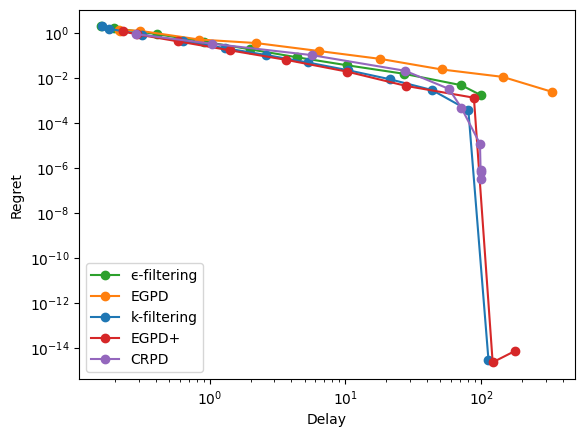

In [10]:
specific.pop('Taboo', None)
xps = xp_builder({'model': codomino, 'rewards': rewards, **common}, specific)
with Pool() as p:
    res = evaluate(xps, pool=p, cache_name="codomino-injective", 
                   cache_overwrite=refresh)
display_res(res)

#### Codomino, bijective

In [11]:
codomino.rates = [4, 5, 5, 3, 3, 2]
codomino.optimize_rates(rewards)

array([1., 3., 1., 3., 1., 0., 2., 0.])

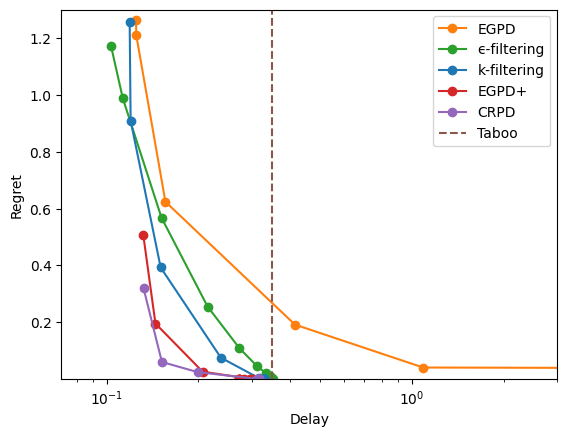

In [12]:
specific['Taboo'] = taboo
xps = xp_builder({'model': codomino, 'rewards': rewards, **common}, specific)
with Pool() as p:
    res = evaluate(xps, pool=p, cache_name="codomino-bijective", 
                   cache_overwrite=refresh)
display_res(res, view='logx', x_max=3, y_max=1.3)

### Larger graphs

In [13]:
np.random.seed(42)
n = 100
p = 20 / (n-1)
edges = np.triu(np.random.rand(n, n) < p, 1)
adjacency = edges+edges.T
int(np.sum(adjacency))//2

1006

#### Injective-only

In [14]:
er = sm.Model(adjacency=adjacency)
rewards = np.random.rand(er.m)

In [15]:
vertex = er.optimize_rates(rewards)
np.sum(vertex>0)

np.int64(97)

  0%|          | 0/52 [00:00<?, ?it/s]

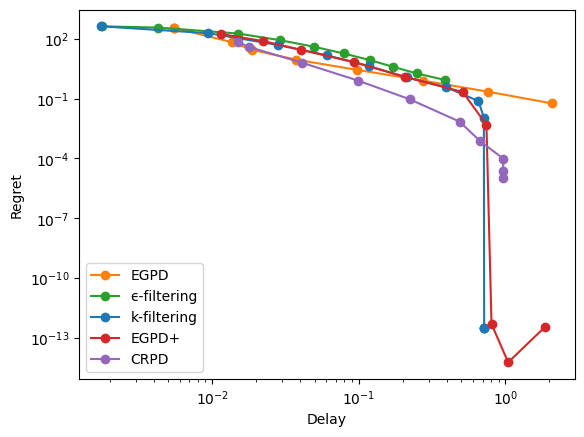

In [16]:
specific.pop('Taboo', None)
xps = xp_builder({'model': er, 'rewards': rewards, **common}, specific)
with Pool(4) as p:
    res = evaluate(xps, pool=p, cache_name="er-injective", 
                   cache_overwrite=refresh)
display_res(res)

#### Bijective

In [17]:
np.random.seed(42)
er.rates = er.rates + 5*np.random.rand(n)
vertex = er.optimize_rates(rewards)
np.sum(vertex>0)

np.int64(100)

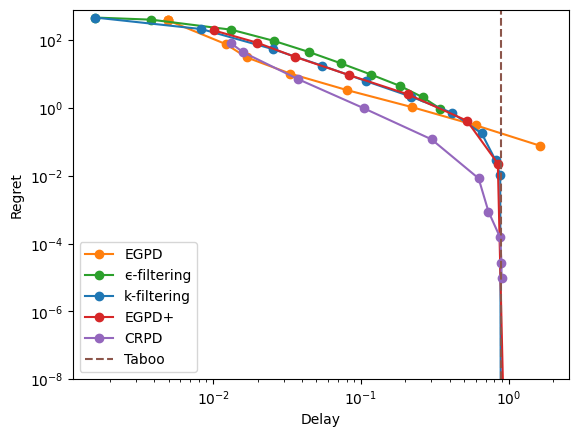

In [30]:
specific['Taboo'] = taboo 
xps = xp_builder({'model': er, 'rewards': rewards, **common}, specific)
with Pool(4) as p:
    res = evaluate(xps, pool=p, cache_name="er-bijective", 
                   cache_overwrite=refresh)
display_res(res, y_max=800)

## Approaching vertices of hypergraphs

### Abandonment

### Nazari & Stolyar example

See https://arxiv.org/abs/1608.01646 for details.

#### First arrival rates

In [19]:
ns19 = sm.NS19(rates=[1.2, 1.5, 2, 0.8])
rewards = [-1, -1, 1, 2, 5, 4, 7]
ns19.optimize_rates(rewards)

array([0. , 0. , 1.7, 0.5, 1.2, 0. , 0.3])

We now have hypergraphs. We need to adjust some policy settings accordingly, switching from *longest queue* to *virtual queue* to ensure stability.

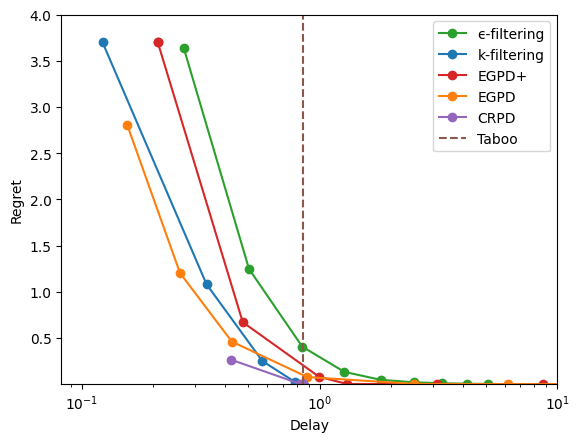

In [20]:
for k in ['k-filtering', 'Taboo']:
    specific[k]['simulator'] = 'virtual_queue'
    specific[k]['alt_rewards'] = 'gentle'
specific['ϵ-filtering']['base_policy'] = 'virtual_queue'
xps = xp_builder({'model': ns19, 'rewards': rewards, **common}, specific)
with Pool() as p:
    res = evaluate(xps, pool=p, cache_name="ns19-a", cache_overwrite=refresh)
display_res(res, view='logx', x_max=10, y_max=4)

#### Second arrival rates

In [21]:
ns19.rates = [1.8, .8, 1.4, 1]
ns19.optimize_rates(rewards)

array([1. , 0. , 1.4, 1. , 0.8, 0. , 0. ])

In [22]:
xps = xp_builder({'model': ns19, 'rewards': rewards, **common}, specific)
with Pool() as p:
    res = evaluate(xps, pool=p, cache_name="ns19-b", cache_overwrite=refresh)

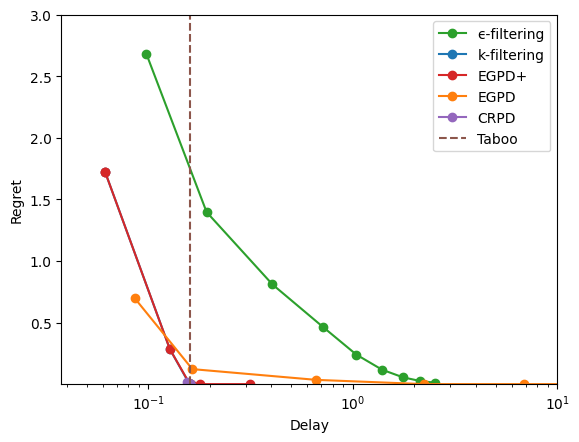

In [23]:
display_res(res, view='logx', x_max=10, y_max=3)

## Flexibility of greedy policies

### Complete graph

For complete graphs, all greedy policies are equivalent because there is never any true choice to make in that case. Let us check that by running a few greedy policies.

We will use the graph $K_4$, which has a 2-D kernel. With uniform arrival rates, its polytope is a triangle.

In [24]:
complete = sm.Complete(n=4)
complete.vertices

[{'kernel_coordinates': array([-1., -1.]),
  'edge_coordinates': array([0., 0., 3., 3., 0., 0.]),
  'null_edges': [0, 1, 4, 5],
  'bijective': False},
 {'kernel_coordinates': array([-1.,  2.]),
  'edge_coordinates': array([3., 0., 0., 0., 0., 3.]),
  'null_edges': [1, 2, 3, 4],
  'bijective': False},
 {'kernel_coordinates': array([ 2., -1.]),
  'edge_coordinates': array([0., 3., 0., 0., 3., 0.]),
  'null_edges': [0, 2, 3, 5],
  'bijective': False}]

For the comparison, we will consider the following greedy policies:

In [25]:
base = {"model": complete, "n_steps": n_steps, "seed": 42}
xps = sum(
    [
        XP("Longest", simulator="longest", **base),
        XP("FCFM", simulator="fcfm", **base),
        XP("Random Edge", simulator="random_edge", **base),
        XP("Random Item", simulator="random_item", **base),
        XP("Priority", simulator="priority", weights=[1, 10, 0, -1, 3, 4], **base),
    ]
)

We run the simulation, gathering the resulting matching rate in edge and kernel coordinates:

In [26]:
def flow_kernel_coordinates(simu):
    flow = simu.flow
    return simu.model.edge_to_kernel(flow)

with Pool(5) as p:
    res = evaluate(
        xps, ["flow", flow_kernel_coordinates], pool=p, cache_name="complete", 
        cache_overwrite=refresh
    )
res

{'Longest': {'flow': array([1.0004664, 1.0011504, 0.9990264, 1.0000548, 0.9989808, 1.0003212]),
  'flow_kernel_coordinates': array([0., 0.])},
 'FCFM': {'flow': array([1.0004664, 1.0011504, 0.9990264, 1.0000548, 0.9989808, 1.0003212]),
  'flow_kernel_coordinates': array([0., 0.])},
 'Random Edge': {'flow': array([1.0001556, 0.9993492, 1.0021224, 0.999738 , 0.999762 , 0.9988728]),
  'flow_kernel_coordinates': array([0., 0.])},
 'Random Item': {'flow': array([1.0001556, 0.9993492, 1.0021224, 0.999738 , 0.999762 , 0.9988728]),
  'flow_kernel_coordinates': array([0., 0.])},
 'Priority': {'flow': array([1.0004664, 1.0011504, 0.9990264, 1.0000548, 0.9989808, 1.0003212]),
  'flow_kernel_coordinates': array([0., 0.])}}

:::tip
In the results above, the randomized policies (on Items and Edges) have not exactly the same rate than the deterministic policies, despite the use of a seed. The reason is that there is one unique random generator per simulator, so having a randomized policy impacts the drawing of arrivals (even if the number of possibilities is always reduced to 1).
:::

### Diamond

### Fish graph